In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

In [4]:
## Load datasets
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
economic_df = pd.read_csv("EconomicIndicators.csv")
sample_submission_df = pd.read_csv("sample_submission.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525 entries, 0 to 524
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Quarter         525 non-null    object 
 1   Company         525 non-null    object 
 2   InventoryRatio  419 non-null    float64
 3   RevenueGrowth   525 non-null    float64
 4   Marketshare     525 non-null    float64
 5   Bond rating     525 non-null    object 
 6   Stock rating    525 non-null    object 
 7   Region          525 non-null    object 
 8   Industry        525 non-null    object 
 9   QuickRatio      525 non-null    float64
 10  Sales           525 non-null    int64  
dtypes: float64(4), int64(1), object(6)
memory usage: 45.2+ KB
Train Data Summary:
 None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   RowID           150 n

C:\Users\ishra\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ishra\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ishra\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ishra\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

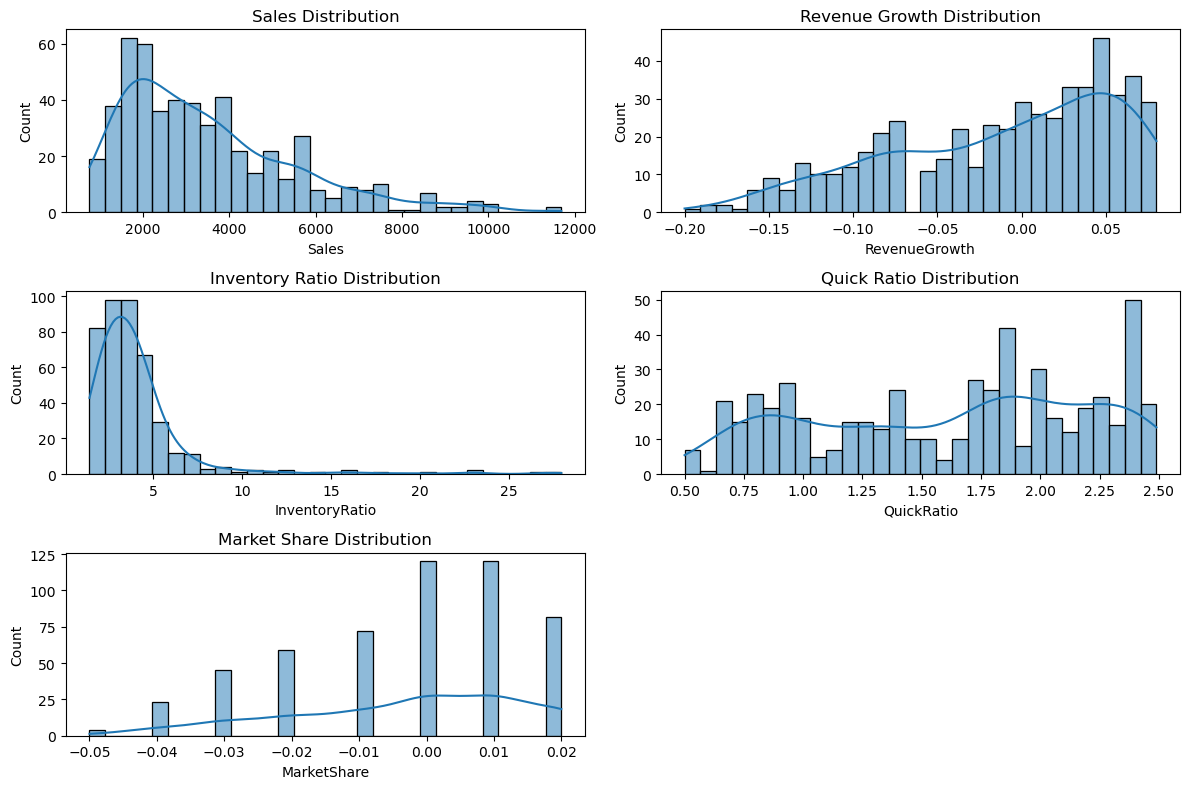

In [5]:
# Exploratory Data Analysis (EDA)
print("Train Data Summary:\n", train_df.info())
print("Test Data Summary:\n", test_df.info())

# Check for missing values
print("Missing values in Train Data:\n", train_df.isnull().sum())
print("Missing values in Test Data:\n", test_df.isnull().sum())

# Summary statistics
print("Train Data Description:\n", train_df.describe())
print("Test Data Description:\n", test_df.describe())

# Plot distributions of key numerical features
fig, axes = plt.subplots(3, 2, figsize=(12, 8))

sns.histplot(train_df['Sales'], bins=30, kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Sales Distribution")
axes[0, 0].set_xlabel("Sales")
axes[0, 0].set_ylabel("Count")

sns.histplot(train_df['RevenueGrowth'], bins=30, kde=True, ax=axes[0, 1])
axes[0, 1].set_title("Revenue Growth Distribution")
axes[0, 1].set_xlabel("RevenueGrowth")
axes[0, 1].set_ylabel("Count")

sns.histplot(train_df['InventoryRatio'], bins=30, kde=True, ax=axes[1, 0])
axes[1, 0].set_title("Inventory Ratio Distribution")
axes[1, 0].set_xlabel("InventoryRatio")
axes[1, 0].set_ylabel("Count")

sns.histplot(train_df['QuickRatio'], bins=30, kde=True, ax=axes[1, 1])
axes[1, 1].set_title("Quick Ratio Distribution")
axes[1, 1].set_xlabel("QuickRatio")
axes[1, 1].set_ylabel("Count")

sns.histplot(train_df['Marketshare'], bins=30, kde=True, ax=axes[2, 0])
axes[2, 0].set_title("Market Share Distribution")
axes[2, 0].set_xlabel("MarketShare")
axes[2, 0].set_ylabel("Count")

axes[2, 1].axis("off")  # Hide the empty subplot

plt.tight_layout()
plt.show()

In [6]:
# === 2. DATA PREPROCESSING ===

# Convert Quarter format
train_df["Quarter"] = train_df["Quarter"].str.replace("Q", "").astype(int)
test_df["Quarter"] = test_df["Quarter"].str.replace("Q", "").astype(int)
economic_df["Quarter"] = ((economic_df["Month"] - 1) // 3 + 1)

# Economic indicators rolling averages
economic_df = economic_df.sort_values("Month")
economic_df["ConsumerSentiment_RollingMean"] = economic_df["Consumer Sentiment"].rolling(window=3, min_periods=1).mean()
economic_df["InterestRate_RollingMean"] = economic_df["Interest Rate"].rolling(window=3, min_periods=1).mean()
economic_df["PMI_RollingMean"] = economic_df["PMI"].rolling(window=3, min_periods=1).mean()
economic_df["MoneySupply_RollingMean"] = economic_df["Money Supply"].rolling(window=3, min_periods=1).mean()
quarterly_econ = economic_df.groupby("Quarter").mean(numeric_only=True).reset_index()

# Handle missing InventoryRatio
for df in [train_df, test_df]:
    df["InventoryRatio"] = df.groupby("Company")["InventoryRatio"].transform(lambda x: x.fillna(x.median()))
    df["InventoryRatio"].fillna(df["InventoryRatio"].median(), inplace=True)

# Merge economic data
train_df = train_df.merge(quarterly_econ, on="Quarter", how="left")
test_df = test_df.merge(quarterly_econ, on="Quarter", how="left")

# Fill remaining missing values
train_df.fillna(train_df.median(numeric_only=True), inplace=True)
test_df.fillna(test_df.median(numeric_only=True), inplace=True)

# Keep only Q1–Q7 for training
train_df = train_df[train_df["Quarter"] <= 7]


C:\Users\ishra\AppData\Local\Temp\ipykernel_4544\1913812346.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["InventoryRatio"].fillna(df["InventoryRatio"].median(), inplace=True)
C:\Users\ishra\AppData\Local\Temp\ipykernel_4544\1913812346.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beh

In [7]:
# === 3. FEATURE ENGINEERING ===

# Lag features
train_df = train_df.sort_values(by=["Company", "Quarter"])
train_df["Sales_Lag_1"] = train_df.groupby("Company")["Sales"].shift(1)
train_df["Sales_Lag_2"] = train_df.groupby("Company")["Sales"].shift(2)
train_df["Sales_Lag_3"] = train_df.groupby("Company")["Sales"].shift(3)
train_df["Average_Sales_Last_2"] = (train_df["Sales_Lag_1"] + train_df["Sales_Lag_2"]) / 2
train_df["Sales_Trend"] = train_df["Sales_Lag_1"] - train_df["Sales_Lag_2"]

for col in ["Sales_Lag_1", "Sales_Lag_2", "Sales_Lag_3", "Average_Sales_Last_2", "Sales_Trend"]:
    train_df[col].fillna(train_df[col].median(), inplace=True)

# Company-level stats
company_stats = train_df.groupby("Company")["Sales"].agg(["mean", "std"]).reset_index()
company_stats.rename(columns={"mean": "Company_Avg_Sales", "std": "Company_Sales_STD"}, inplace=True)
train_df = train_df.merge(company_stats, on="Company", how="left")
test_df = test_df.merge(company_stats, on="Company", how="left")
test_df.fillna(test_df.median(numeric_only=True), inplace=True)

# Categorical encoding
for col in ["Bond rating", "Stock rating", "Industry"]:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])
    test_df[col] = le.transform(test_df[col])

# Region one-hot encoding
train_df = pd.get_dummies(train_df, columns=["Region"], drop_first=False)
test_df = pd.get_dummies(test_df, columns=["Region"], drop_first=False)
for col in set(train_df.columns).union(set(test_df.columns)):
    if "Region_" in col:
        train_df[col] = train_df.get(col, 0)
        test_df[col] = test_df.get(col, 0)

# Final training data
X_train = train_df.drop(columns=["Company", "Sales"])
y_train = train_df["Sales"]


C:\Users\ishra\AppData\Local\Temp\ipykernel_4544\940224722.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df[col].fillna(train_df[col].median(), inplace=True)


In [8]:
# === 4. MODEL TRAINING WITH GRIDSEARCHCV ===

param_grid = {
    "n_estimators": [300, 400, 500],
    "learning_rate": [0.01, 0.02, 0.03],
    "max_depth": [5, 6, 7],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

grid_search = GridSearchCV(
    XGBRegressor(random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=5,
    verbose=2,
    n_jobs=1
)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

print("\n Best Hyperparameters Found:", grid_search.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=1.0; total time=   0.2s
[CV] END 


 Validation MAE (20% split): 69.29
 Training MAE (100%): 60.85


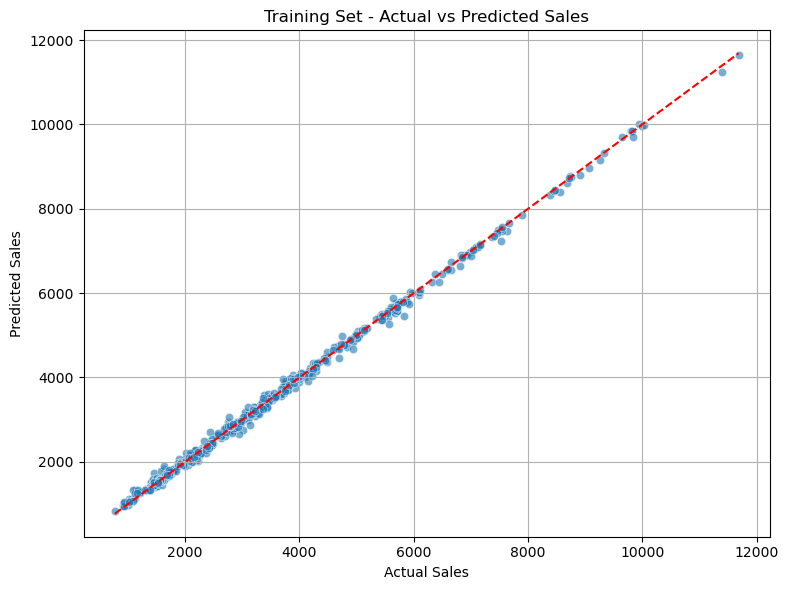

In [12]:
# === 5. MODEL PERFORMANCE EVALUATION ===

X_train_part, X_val_part, y_train_part, y_val_part = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

y_val_pred = best_model.predict(X_val_part)
val_mae = mean_absolute_error(y_val_part, y_val_pred)
print(f"\n Validation MAE (20% split): {val_mae:.2f}")

y_train_pred = best_model.predict(X_train)
train_mae = mean_absolute_error(y_train, y_train_pred)
print(f" Training MAE (100%): {train_mae:.2f}")

# Plot: Actual vs Predicted (Training)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_train, y=y_train_pred, alpha=0.6)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Training Set - Actual vs Predicted Sales")
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
# === 6. Q8 & Q9 PREDICTION ===

# Predict Q8
test_q8 = test_df[test_df["Quarter"] == 8].copy()
test_q9 = test_df[test_df["Quarter"] == 9].copy()

q7 = train_df[train_df["Quarter"] == 7][["Company", "Sales"]].rename(columns={"Sales": "Sales_Lag_1"})
q6 = train_df[train_df["Quarter"] == 6][["Company", "Sales"]].rename(columns={"Sales": "Sales_Lag_2"})
q5 = train_df[train_df["Quarter"] == 5][["Company", "Sales"]].rename(columns={"Sales": "Sales_Lag_3"})

test_q8 = test_q8.merge(q7, on="Company", how="left")
test_q8 = test_q8.merge(q6, on="Company", how="left")
test_q8 = test_q8.merge(q5, on="Company", how="left")
test_q8["Average_Sales_Last_2"] = (test_q8["Sales_Lag_1"] + test_q8["Sales_Lag_2"]) / 2
test_q8["Sales_Trend"] = test_q8["Sales_Lag_1"] - test_q8["Sales_Lag_2"]

X_q8 = test_q8[X_train.columns]
test_q8["Sales"] = best_model.predict(X_q8)

# Predict Q9 using Q8's predicted Sales
q8_pred = test_q8[["Company", "Sales"]].rename(columns={"Sales": "Sales_Lag_1"})
q7_actual = train_df[train_df["Quarter"] == 7][["Company", "Sales"]].rename(columns={"Sales": "Sales_Lag_2"})
q6_actual = train_df[train_df["Quarter"] == 6][["Company", "Sales"]].rename(columns={"Sales": "Sales_Lag_3"})

q8q9 = test_q9.merge(q8_pred, on="Company", how="left")
q8q9 = q8q9.merge(q7_actual, on="Company", how="left")
q8q9 = q8q9.merge(q6_actual, on="Company", how="left")
q8q9["Average_Sales_Last_2"] = (q8q9["Sales_Lag_1"] + q8q9["Sales_Lag_2"]) / 2
q8q9["Sales_Trend"] = q8q9["Sales_Lag_1"] - q8q9["Sales_Lag_2"]

X_q9 = q8q9[X_train.columns]
q8q9["Sales"] = best_model.predict(X_q9)

# Combine Q8 and Q9 predictions
final_preds = pd.concat([test_q8, q8q9], axis=0).sort_values(by=["Company", "Quarter"]).reset_index(drop=True)


In [14]:
# === 7. SAVE SUBMISSION FILE ===
submission = sample_submission_df.copy()
submission["Sales"] = final_preds["Sales"].values
submission.to_csv("submission_q8_q9_gridsearch.csv", index=False)
print("\n Submission file saved: submission_q8_q9_gridsearch.csv")


 Submission file saved: submission_q8_q9_gridsearch.csv
